In [3]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.calibration import calibration_curve 
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Bidirectional, Dense, concatenate, Dropout, Input
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from keras.regularizers import l1_l2
from keras.models import Sequential
import tensorflow.compat.v1 as tf
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from textblob import TextBlob
from afinn import Afinn
from pattern.en import sentiment
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
nltk.download('punkt')
from sklearn.metrics import precision_recall_curve, average_precision_score

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\maddy\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\maddy\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
df=pd.read_csv('truthseeker_emotions.csv')
df.head(5)

,Unnamed: 0,author,statement,target,BinaryNumTarget,manual_keywords,tweet,5_label_majority_answer,3_label_majority_answer,anger,disgust,fear,joy,neutral,sadness,surprise
0,0,D.L. Davis,End of eviction moratorium means millions of A...,True,1.0,"Americans, eviction moratorium",@POTUS Biden Blunders - 6 Month Update\n\nInfl...,Mostly Agree,Agree,0,0,0,0,0,1,0
1,1,D.L. Davis,End of eviction moratorium means millions of A...,True,1.0,"Americans, eviction moratorium",@S0SickRick @Stairmaster_ @6d6f636869 Not as m...,NO MAJORITY,Agree,0,0,0,0,0,1,0
2,2,D.L. Davis,End of eviction moratorium means millions of A...,True,1.0,"Americans, eviction moratorium",THE SUPREME COURT is siding with super rich pr...,Agree,Agree,0,0,0,0,0,1,0
3,3,D.L. Davis,End of eviction moratorium means millions of A...,True,1.0,"Americans, eviction moratorium",@POTUS Biden Blunders\n\nBroken campaign promi...,Mostly Agree,Agree,0,0,0,0,0,1,0
4,4,D.L. Davis,End of eviction moratorium means millions of A...,True,1.0,"Americans, eviction moratorium",@OhComfy I agree. The confluence of events rig...,Agree,Agree,0,0,0,0,0,1,0


In [5]:
df['textblob'] = df['tweet'].apply(lambda x: TextBlob(x).sentiment.polarity)
afinn = Afinn()
df['afinn'] = df['tweet'].apply(lambda x: afinn.score(x))
df['pattern'] = df['tweet'].apply(lambda x: sentiment(x)[0])
analyzer = SentimentIntensityAnalyzer()

df['vader'] = df['tweet'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

In [6]:
selected_columns = ['statement','tweet', 'BinaryNumTarget', 'anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise',
                    'afinn', 'pattern', 'vader', 'textblob']

In [7]:
df1 = df[selected_columns]

In [8]:
df1.head(3)

,statement,tweet,BinaryNumTarget,anger,disgust,fear,joy,neutral,sadness,surprise,afinn,pattern,vader,textblob
0,End of eviction moratorium means millions of A...,@POTUS Biden Blunders - 6 Month Update\n\nInfl...,1.0,0,0,0,0,0,1,0,-7.0,0.500000,-0.9169,0.500000
1,End of eviction moratorium means millions of A...,@S0SickRick @Stairmaster_ @6d6f636869 Not as m...,1.0,0,0,0,0,0,1,0,-10.0,0.125000,-0.9449,0.125000
2,End of eviction moratorium means millions of A...,THE SUPREME COURT is siding with super rich pr...,1.0,0,0,0,0,0,1,0,1.0,0.206667,-0.3147,0.206667


In [9]:
df1['BinaryNumTarget'] = df1['BinaryNumTarget'].astype(int)

C:\Users\maddy\AppData\Local\Temp\ipykernel_10444\97325919.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['BinaryNumTarget'] = df1['BinaryNumTarget'].astype(int)


In [10]:
df1.shape

(134198, 14)

In [50]:
X_text = df1['tweet']+df1['statement'].values
X_emotions = df1[['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']].values
X_scores = df1[['afinn', 'pattern', 'vader', 'textblob']].values
y = df1['BinaryNumTarget'].values


In [12]:
statements = df1['statement']+df1['tweet']

max_len_text = max(len(statement.split()) for statement in statements)

print("Maximum length of statements:", max_len_text)

Maximum length of statements: 141


In [13]:
max_len_text = max_len_text  
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_text)
sequences = tokenizer.texts_to_sequences(X_text)
X_text_pad = pad_sequences(sequences, maxlen=max_len_text)

In [14]:
embedding_dim = 100  
vocab_size = len(tokenizer.word_index) + 1

In [16]:
from tensorflow.keras.models import load_model
model = load_model('fake_news_detection_LSTM.h5')

In [52]:
predictions = model.predict([X_text_pad, X_emotions, X_scores])

4194/4194 [==============================] - 100s 24ms/step


In [98]:
y_pred = (predictions > 0.65).astype(int)

In [117]:
accuracy = accuracy_score(y, y_pred)
precision = precision_score(y, y_pred)
recall = recall_score(y, y_pred)
f1 = f1_score(y, y_pred)
cm = confusion_matrix(y, y_pred)

In [118]:
print("Confusion Matrix:\n", cm)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

Confusion Matrix:
 [[65268     0]
 [    2 68928]]
Accuracy: 0.9999850966482362
Precision: 1.0
Recall: 0.9999709850573045
F1-Score: 0.9999854923181826


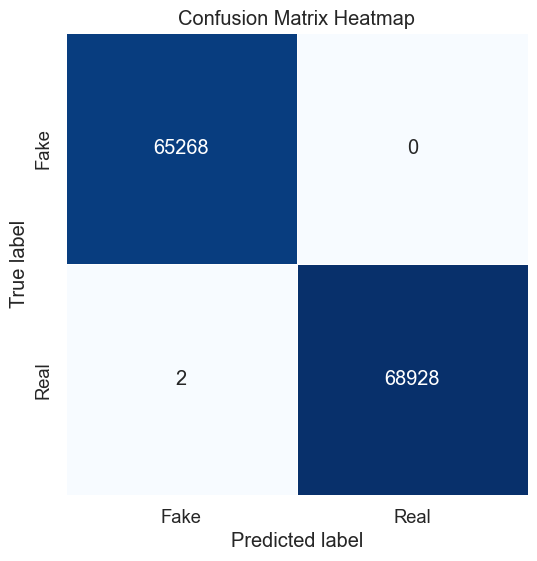

In [131]:
cm = confusion_matrix(y, y_pred)

# Define class labels
classes = ['Fake', 'Real'] 
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font size
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, square=True,
            xticklabels=classes, yticklabels=classes, linewidths=0.5)
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

#### the model correctly predicts true negativers and true positives

## Calibration Curve

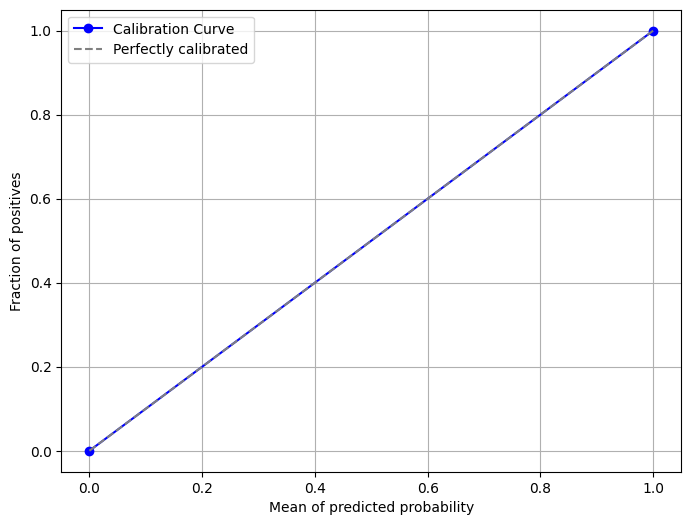

In [123]:
prob_true, prob_pred = calibration_curve(y, predictions, n_bins=10, strategy='uniform')
plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', color='b', label='Calibration Curve')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly calibrated')
plt.xlabel('Mean of predicted probability')
plt.ylabel('Fraction of positives')
plt.legend()
plt.grid(True)
plt.show()

#### The model is perfectly calibrated making it effective in identifying a news as real or fake

In [103]:
fpr, tpr, thresholds = roc_curve(y, predictions)
roc_auc = auc(fpr, tpr)

In [104]:

precision_curve, recall_curve, thresholds = precision_recall_curve(y, predictions)
precision_curve_interp = np.interp(recall_curve, recall_curve[::-1], precision_curve[::-1])
# length of thresholds
n = len(precision_curve_interp)
thresholds_subset = thresholds[-n:]


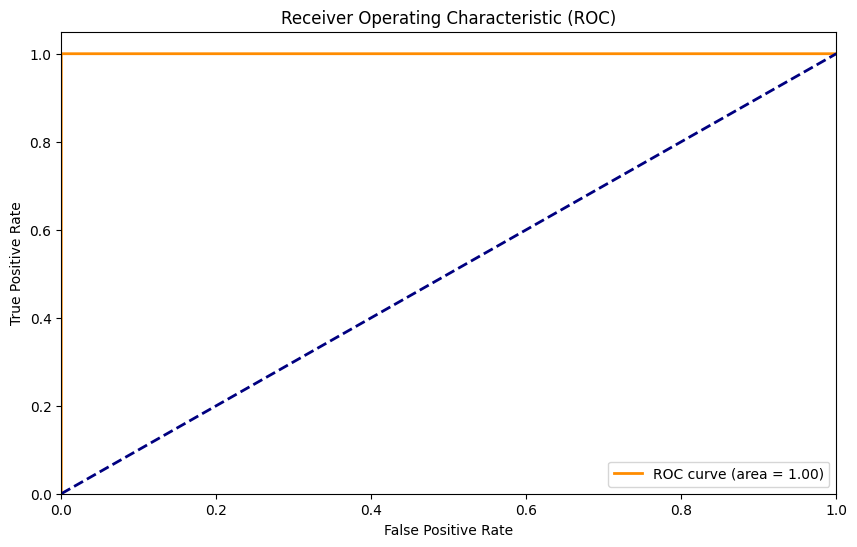

In [106]:
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


## The model has a perfect ability to distinguish between the two classes based on the AUC and ROC curves